# ケーブルコネクタコンペのチュートリアル 物体検出・クラス分類編 YOLOv5

### はじめに
* このチュートリアルではYOLOを用いた物体検出・クラス分類の学習・推論を行う方法について紹介します。
    * YOLOv5で学習を行うためのデータ加工方法、YOLOv5で推論を行ったときの出力フォーマットについて紹介します。
    * YOLOv5での推論は物体検出の座標、クラス、確信度を出力することができるのですが、このチュートリアルではこのクラスをもとにsubmission.csvを作成するところまで行います。
* 別で公開したefficientnetとのアンサンブルを行ったり、YOLOv5で物体検出を行い背景を除去した上でefficientnetクラス分類を行ったりいろいろな手法が試せるかと思いますので是非ご活用いただければと思います。

### 目次
* ColabでYOLOv5実行環境構築
* YOLOv5 学習用データ作成
* YOLOv5 学習
* YOLOv5 推論
* submission.csv作成


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ColabでYOLOv5実行環境構築
以下のgithubよりyolov5レポジトリをクローンしrequirements.txtに記載のライブラリのインストールする
* https://github.com/ultralytics/yolov5

In [2]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9876, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 9876 (delta 93), reused 138 (delta 91), pack-reused 9734
Receiving objects: 100% (9876/9876), 10.05 MiB | 36.89 MiB/s, done.
Resolving deltas: 100% (6871/6871), done.


In [3]:
%cd yolov5/
!pip install -qr requirements.txt

/content/yolov5
     |████████████████████████████████| 596 kB 7.4 MB/s 


In [4]:
!ls "/content/yolov5"

CONTRIBUTING.md  Dockerfile  LICENSE	requirements.txt  utils
data		 export.py   models	train.py	  val.py
detect.py	 hubconf.py  README.md	tutorial.ipynb


In [5]:
!ls "/content/drive/My Drive/Python/Kaggle/nishika/resize_data"

additional_data		   df_train_resized.csv  train
additional_resize_jpg.zip  test			 train_resize_jpg.zip
df_additional_resized.csv  test_resize_jpg.zip


### 画像データをマイドライブからコピーしcontentへ展開
* コンペページより入手できる画像データを使うのではなく、別のチュートリアルで公開したresize後の画像データを使っております。※ reseize後はサイズを512,512に統一しております。
* オリジナルの画像はサイズが非常に大きいため、resize後の画像を使って効率的に学習を行います。

In [6]:
!mkdir datasets

### data.zipから解凍する

#!cp "/content/drive/My Drive/Python/Kaggle/nishika/data.zip" /content/

#!unzip /content/data.zip -d "/content/datasets"

#!unzip /content/datasets/train_image.zip -d "/content/datasets/"
#!unzip /content/datasets/test_image.zip -d "/content/datasets/"
#!unzip /content/datasets/additional_image.zip -d "/content/datasets/"


### マイドライブのresize jpgから解凍する
!cp "/content/drive/My Drive/Python/Kaggle/nishika/resize_data/train_resize_jpg.zip" /content/
!cp "/content/drive/My Drive/Python/Kaggle/nishika/resize_data/test_resize_jpg.zip" /content/
!cp "/content/drive/My Drive/Python/Kaggle/nishika/resize_data/additional_resize_jpg.zip" /content/


!unzip /content/train_resize_jpg.zip -d "/content/datasets"
!unzip /content/test_resize_jpg.zip -d "/content/datasets"
!unzip /content/additional_resize_jpg.zip -d "/content/datasets"


ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/datasets/train/836477d3.jpg  
  inflating: /content/datasets/train/8379c02e.jpg  
  inflating: /content/datasets/train/83a0a065.jpg  
  inflating: /content/datasets/train/83ba9bed.jpg  
  inflating: /content/datasets/train/83c7b7f6.jpg  
  inflating: /content/datasets/train/83f317ef.jpg  
  inflating: /content/datasets/train/845548b9.jpg  
  inflating: /content/datasets/train/84961ee2.jpg  
  inflating: /content/datasets/train/84bdcd15.jpg  
  inflating: /content/datasets/train/84d133d9.jpg  
  inflating: /content/datasets/train/84d5d511.jpg  
  inflating: /content/datasets/train/8506ef9d.jpg  
  inflating: /content/datasets/train/854c9a6a.jpg  
  inflating: /content/datasets/train/856aca9a.jpg  
  inflating: /content/datasets/train/85a915d1.jpg  
  inflating: /content/datasets/train/85c525b0.jpg  
  inflating: /content/datasets/train/85c7fe93.jpg  
  inflating: /content/datasets/train/85ffd4a3.jpg  
  inflating: /content/datasets/t

In [7]:
import numpy as np
import pandas as pd
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader

from glob import glob
from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval
import ast

from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

from  sklearn.model_selection  import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

from IPython.display import Image, clear_output 

In [8]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

SEED = 42

In [9]:
## For colab
DATA_ROOT = "/content/datasets/"
TRAIN_IMAGES_ROOT = "/content/datasets/train/"
TEST_IMAGES_ROOT = "/content/datasets/test/"
ADDITIONAL_IMAGES_ROOT="/content/datasets/additional_data/"

##################################################################
###   自分の環境に合わせる
##################################################################

MYDRIVE = "/content/drive/My Drive/Python/Kaggle/nishika/"
OUTPUT = "/content/drive/My Drive/Python/Kaggle/nishika/output/"


In [10]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cuda


In [11]:
### 画像縮小チュートリアルで作成したresized後の物体検出アノテーションがあるデータフレームの読み込み

df_train = pd.read_csv(MYDRIVE+"resize_data/df_train_resized.csv")
df_train

,filename,Xmin_Ymin_Xmax_Ymax,class,resized_box
0,2f71963a.jpg,"[921, 1510, 1558, 2207]",HDMI,"[156, 192, 264, 280]"
1,8cdf4bda.jpg,"[1442, 1525, 1722, 2000]",USB_Mini,"[244, 194, 292, 254]"
2,7ac35f30.jpg,"[666, 1671, 1990, 2259]",Dock,"[113, 212, 337, 287]"
3,f6641c06.jpg,"[1242, 1753, 1789, 2115]",Lightning,"[210, 223, 303, 269]"
4,4fdc8d7d.jpg,"[1572, 1050, 2231, 1691]",USB_Micro_B,"[266, 133, 378, 215]"
...,...,...,...,...
2366,f51ca7d8.jpg,"[678, 1276, 2088, 2355]",USB_Type_B,"[115, 162, 354, 299]"
2367,323b4f3c.jpg,"[1564, 2003, 2116, 2307]",USB_Type_C,"[267, 256, 361, 295]"
2368,5f60288f.jpg,"[1273, 1816, 2275, 2784]",RJ_45,"[216, 231, 385, 354]"
2369,eaea09d6.jpg,"[863, 1838, 1213, 2054]",USB_Micro_B,"[205, 245, 288, 274]"


In [12]:
df_train.drop(['Xmin_Ymin_Xmax_Ymax'],axis=1,inplace=True)

In [13]:
df_train

,filename,class,resized_box
0,2f71963a.jpg,HDMI,"[156, 192, 264, 280]"
1,8cdf4bda.jpg,USB_Mini,"[244, 194, 292, 254]"
2,7ac35f30.jpg,Dock,"[113, 212, 337, 287]"
3,f6641c06.jpg,Lightning,"[210, 223, 303, 269]"
4,4fdc8d7d.jpg,USB_Micro_B,"[266, 133, 378, 215]"
...,...,...,...
2366,f51ca7d8.jpg,USB_Type_B,"[115, 162, 354, 299]"
2367,323b4f3c.jpg,USB_Type_C,"[267, 256, 361, 295]"
2368,5f60288f.jpg,RJ_45,"[216, 231, 385, 354]"
2369,eaea09d6.jpg,USB_Micro_B,"[205, 245, 288, 274]"


In [14]:
df_test = pd.read_csv(MYDRIVE+"/sample_submission.csv")
df_test

,filename,class
0,997195ba.jpg,USB_Type_C
1,9f3f263d.jpg,USB_Type_C
2,1072aa7d.jpg,USB_Type_C
3,f8047293.jpg,USB_Type_C
4,3dccb562.jpg,USB_Type_C
...,...,...
2195,4eae2d46.jpg,USB_Type_C
2196,ceadcae4.jpg,USB_Type_C
2197,4a5a3544.jpg,USB_Type_C
2198,bbc3c7b6.jpg,USB_Type_C


In [15]:
df_additional = pd.read_csv(MYDRIVE+"additional_with_box.csv")
df_additional

,Unnamed: 0,filename,class,resized_box,path
0,0,172e1676.jpg,USB_Micro_B_W,"[198,237,318,302]",/content/datasets/additional/172e1676.jpg
1,1,2ed927e9.jpg,USB_Mini,"[230,223,293,265]",/content/datasets/additional/2ed927e9.jpg
2,2,d62e1c29.jpg,HDMI,"[230,259,298,291]",/content/datasets/additional/d62e1c29.jpg
3,3,e0ccc43c.jpg,VGA,"[191,204,308,256]",/content/datasets/additional/e0ccc43c.jpg
4,4,d6a40317.jpg,Lightning_T,"[197,269,297,332]",/content/datasets/additional/d6a40317.jpg
...,...,...,...,...,...
1643,1643,1a42d526.jpg,Lightning,"[218,240,285,280]",/content/datasets/additional/1a42d526.jpg
1644,1644,6b3c238e.jpg,USB_Type_C,"[236,232,345,394]",/content/datasets/additional/6b3c238e.jpg
1645,1645,587a4905.jpg,USB_Mini,"[195,188,279,235]",/content/datasets/additional/587a4905.jpg
1646,1646,ae600959.jpg,USB_Type_C,"[217,233,307,274]",/content/datasets/additional/ae600959.jpg


In [16]:
df_additional=df_additional.drop('Unnamed: 0',axis=1)
df_additional=df_additional.drop('path',axis=1)

In [17]:

df_additional

,filename,class,resized_box
0,172e1676.jpg,USB_Micro_B_W,"[198,237,318,302]"
1,2ed927e9.jpg,USB_Mini,"[230,223,293,265]"
2,d62e1c29.jpg,HDMI,"[230,259,298,291]"
3,e0ccc43c.jpg,VGA,"[191,204,308,256]"
4,d6a40317.jpg,Lightning_T,"[197,269,297,332]"
...,...,...,...
1643,1a42d526.jpg,Lightning,"[218,240,285,280]"
1644,6b3c238e.jpg,USB_Type_C,"[236,232,345,394]"
1645,587a4905.jpg,USB_Mini,"[195,188,279,235]"
1646,ae600959.jpg,USB_Type_C,"[217,233,307,274]"


In [18]:
### content/datasetsに置いたtrain画像のパスを取得してdf_trainへマージ

train_paths = glob(TRAIN_IMAGES_ROOT+"/*.jpg")

df_train_path = pd.DataFrame({
    "path": train_paths,
})
df_train_path["filename"] = df_train_path["path"].apply(lambda x: x.split("/")[-1][:-4])
df_train["filename"] = df_train["filename"].apply(lambda x: x[:-4])

df_train = pd.merge(df_train, df_train_path, on='filename')
df_train

,filename,class,resized_box,path
0,2f71963a,HDMI,"[156, 192, 264, 280]",/content/datasets/train/2f71963a.jpg
1,8cdf4bda,USB_Mini,"[244, 194, 292, 254]",/content/datasets/train/8cdf4bda.jpg
2,7ac35f30,Dock,"[113, 212, 337, 287]",/content/datasets/train/7ac35f30.jpg
3,f6641c06,Lightning,"[210, 223, 303, 269]",/content/datasets/train/f6641c06.jpg
4,4fdc8d7d,USB_Micro_B,"[266, 133, 378, 215]",/content/datasets/train/4fdc8d7d.jpg
...,...,...,...,...
2366,f51ca7d8,USB_Type_B,"[115, 162, 354, 299]",/content/datasets/train/f51ca7d8.jpg
2367,323b4f3c,USB_Type_C,"[267, 256, 361, 295]",/content/datasets/train/323b4f3c.jpg
2368,5f60288f,RJ_45,"[216, 231, 385, 354]",/content/datasets/train/5f60288f.jpg
2369,eaea09d6,USB_Micro_B,"[205, 245, 288, 274]",/content/datasets/train/eaea09d6.jpg


In [19]:
### content/datasetsに置いたadditional画像のパスを取得してdf_trainへマージ

train_paths = glob(ADDITIONAL_IMAGES_ROOT+"/*.jpg")

df_additional_path = pd.DataFrame({
    "path": train_paths,
})
df_additional_path["filename"] = df_additional_path["path"].apply(lambda x: x.split("/")[-1][:-4])
df_additional["filename"] = df_additional["filename"].apply(lambda x: x[:-4])

df_additional = pd.merge(df_additional, df_additional_path, on='filename')
df_additional

,filename,class,resized_box,path
0,172e1676,USB_Micro_B_W,"[198,237,318,302]",/content/datasets/additional_data/172e1676.jpg
1,2ed927e9,USB_Mini,"[230,223,293,265]",/content/datasets/additional_data/2ed927e9.jpg
2,d62e1c29,HDMI,"[230,259,298,291]",/content/datasets/additional_data/d62e1c29.jpg
3,e0ccc43c,VGA,"[191,204,308,256]",/content/datasets/additional_data/e0ccc43c.jpg
4,d6a40317,Lightning_T,"[197,269,297,332]",/content/datasets/additional_data/d6a40317.jpg
...,...,...,...,...
1643,1a42d526,Lightning,"[218,240,285,280]",/content/datasets/additional_data/1a42d526.jpg
1644,6b3c238e,USB_Type_C,"[236,232,345,394]",/content/datasets/additional_data/6b3c238e.jpg
1645,587a4905,USB_Mini,"[195,188,279,235]",/content/datasets/additional_data/587a4905.jpg
1646,ae600959,USB_Type_C,"[217,233,307,274]",/content/datasets/additional_data/ae600959.jpg


In [20]:
df_train=df_train.append(df_additional,ignore_index=True)

In [21]:
df_train

,filename,class,resized_box,path
0,2f71963a,HDMI,"[156, 192, 264, 280]",/content/datasets/train/2f71963a.jpg
1,8cdf4bda,USB_Mini,"[244, 194, 292, 254]",/content/datasets/train/8cdf4bda.jpg
2,7ac35f30,Dock,"[113, 212, 337, 287]",/content/datasets/train/7ac35f30.jpg
3,f6641c06,Lightning,"[210, 223, 303, 269]",/content/datasets/train/f6641c06.jpg
4,4fdc8d7d,USB_Micro_B,"[266, 133, 378, 215]",/content/datasets/train/4fdc8d7d.jpg
...,...,...,...,...
4014,1a42d526,Lightning,"[218,240,285,280]",/content/datasets/additional_data/1a42d526.jpg
4015,6b3c238e,USB_Type_C,"[236,232,345,394]",/content/datasets/additional_data/6b3c238e.jpg
4016,587a4905,USB_Mini,"[195,188,279,235]",/content/datasets/additional_data/587a4905.jpg
4017,ae600959,USB_Type_C,"[217,233,307,274]",/content/datasets/additional_data/ae600959.jpg


In [22]:
1648+2371

4019

In [23]:
### Xmin_Ymin_Xmax_Ymaxはread_csvするとstr型なので、リストで扱えるように変換
#df_train["Xmin_Ymin_Xmax_Ymax"] = [ast.literal_eval(d) for d in df_train["Xmin_Ymin_Xmax_Ymax"]]
df_train["resized_box"] = [ast.literal_eval(d) for d in df_train["resized_box"]]

### resize後のデータでBOXを可視化

In [24]:
from skimage import exposure
import cv2

def read_img(path):
    data = cv2.imread(path)
    
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return data 

def plot_img(img, size=(7, 7), is_rgb=True, title="", cmap='gray'):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=size)
    plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', img_size=(500,500)):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img_size is not None:
            img = cv2.resize(img, img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

filepath---> 7a5df5ff ,  img shape---> (512, 512, 3) ,  Annotation---> [197, 226, 277, 257]
filepath---> c838df53 ,  img shape---> (512, 512, 3) ,  Annotation---> [172, 172, 357, 322]
filepath---> a9346b00 ,  img shape---> (512, 512, 3) ,  Annotation---> [200, 235, 325, 280]
filepath---> 51054b8a ,  img shape---> (512, 512, 3) ,  Annotation---> [213, 238, 309, 295]
filepath---> 92128c7f ,  img shape---> (512, 512, 3) ,  Annotation---> [234, 233, 305, 268]
filepath---> 88cf9864 ,  img shape---> (512, 512, 3) ,  Annotation---> [171, 217, 318, 321]
filepath---> 61dd8cd5 ,  img shape---> (512, 512, 3) ,  Annotation---> [192, 302, 277, 350]
filepath---> 0e784378 ,  img shape---> (512, 512, 3) ,  Annotation---> [193, 261, 263, 294]


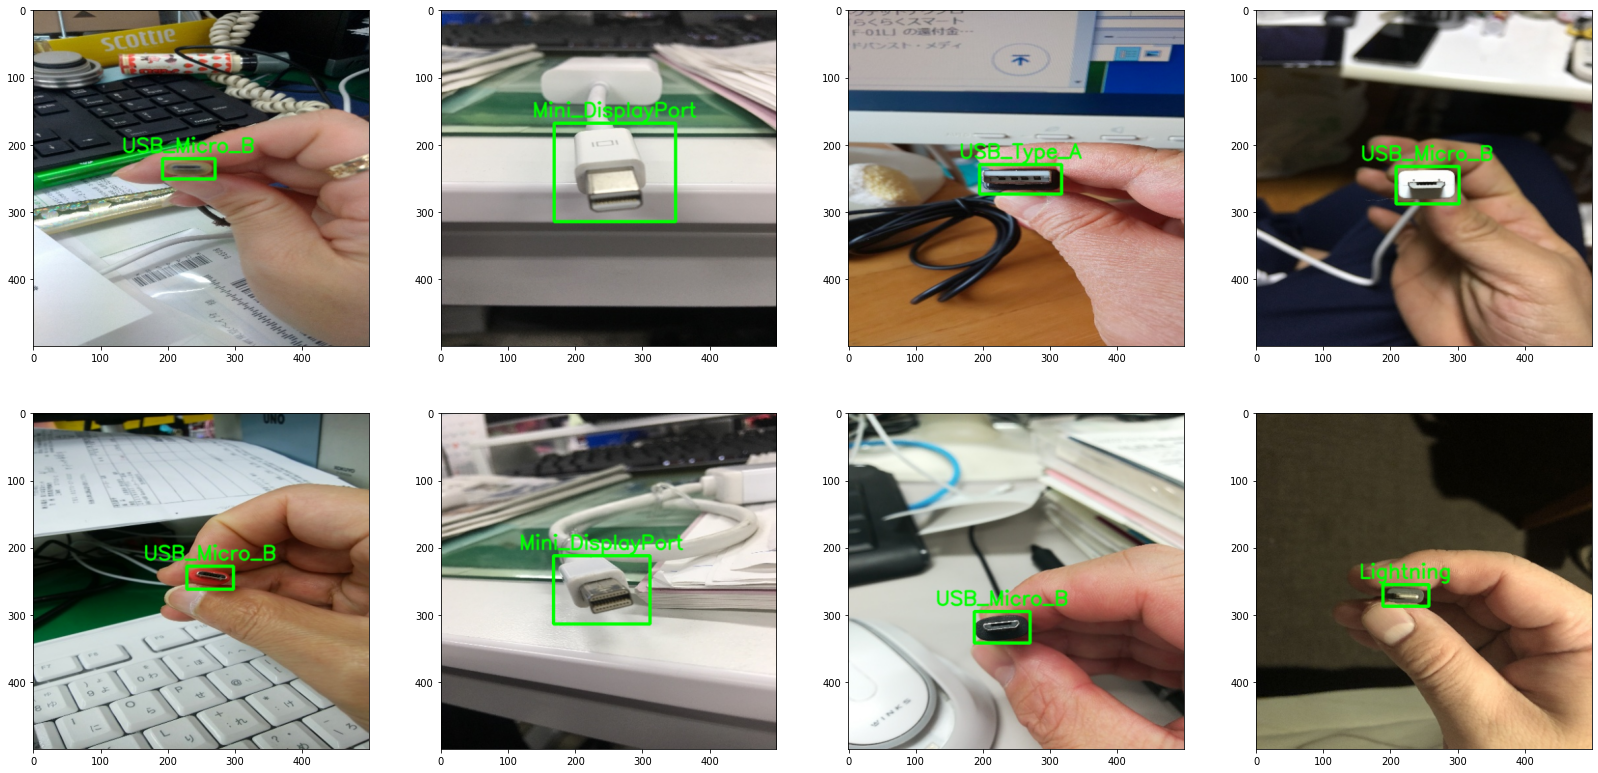

In [25]:
imgs = []

color = [0,255,0]     

thickness = 10
scale = 1
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 5
FONT_THICKNESS = 10
FONT_LINE_TYPE = cv2.LINE_AA

N_read = 8
startid = np.random.randint(0,len(df_train)-N_read)

for _, row in df_train.iloc[startid:startid+N_read].iterrows():
    study_id = row["class"]
    img_path = row['path']
    
    #img = np.load(img_path)
    img = read_img(img_path)

    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
 
    print("filepath--->", row['filename'], ",  img shape--->", img.shape, ",  Annotation--->", row['resized_box'])
 
    target = row["class"]
    box = row['resized_box']

    if img.shape[0]*img.shape[0] > 2400000:
        thickness = 10
        FONT_SCALE = 5
        FONT_THICKNESS = 10
    else:
        thickness = 3
        FONT_SCALE = 1
        FONT_THICKNESS = 2

    text_width, text_height = cv2.getTextSize(target, FONT, FONT_SCALE, FONT_THICKNESS)[0]

    img = cv2.rectangle(
        img,

        (int(box[0]/scale), int(box[1]/scale)),
        (int(box[2]/scale), int(box[3]/scale)),

        color, thickness
    )
    box_width = int(box[2]/scale) - int(box[0]/scale)
    
    img = cv2.putText(img, target, (int(box[0]/scale)-(text_width-box_width)//2, int(box[1]/scale)-10),
                    FONT, FONT_SCALE, color, FONT_THICKNESS, FONT_LINE_TYPE)       
        
    img = cv2.resize(img, (512,512))
    imgs.append(img)
    
plot_imgs(imgs, cmap=None)

## YOLOv5 学習用データ作成

以下のデータを準備する必要があり、このnotebookでは以下のようなディレクトリ構造になるようにデータを作成していきます。  

* 準備が必要なデータ
    * 画像データ train/val
    * labelデータ(txtファイル) train/val
        * class x_center y_center width heightの形式になっている必要があります。またclassはintないしfloatである必要があります。
        * 座標データは0~1のスケールに変換する必要があります。
        * 今回はXmin Ymin Xmax Ymaxの形式でデータを配布しておりますがこれをYolo向けに変換する処理が必要になります。
        *  labelデータの例
        ```
        13 0.453125 0.6298828125 0.1484375 0.126953125 
        ```
    * 画像データのパスが一覧で記載されているデータ(txtファイル) train/val
        * imageフォルダ以下に置いてある画像のパスを改行区切り(\n)で全て記載
        * 画像データのパスが一覧で記載されている例
        ```
        /content/datasets/images/train/b4a9c08c.jpg\n/content/datasets/images/train/d7ccad3f.jpg\n/content/datasets/images/train/b8dab8a0.jpg\n
        ```
    * 以下の情報が記載されたyaml
        * train = train画像パスが一覧になっているtxtファイルのパス
        * val = val画像パスが一覧になっているtxtファイルのパス
        * nc = 分類するクラス数
        * names = クラスの名前が記載されているdict
 ```
 data = dict(
    train = '/content/train.txt' ,
    val   = '/content/val.txt',
    nc   = 15,
    names = classes
)
 ```

* 上記のデータは以下のようなティレクトリ構成になるように配置します。
```
<content>
　├val.txt
　├train.txt
　├sanwa.yaml
　└<datasets>
    ├<images>
    │　├<val>
    │　│　├f64d3578.jpg
    │　│　├88e1a9ff.jpg
    │　│　├15e31b3b.jpg
    │　│　├da5d2641.jpg
    │　│　 ...
    │　└<train>
    │　　　├b4a9c08c.jpg
    │　　　├d7ccad3f.jpg
    │　　　├b8dab8a0.jpg
    │　　　├e68adee7.jpg
    │　   　 ...
    └<labels>
        ├<val>
        │　├993bd943.txt
        │　├de3ab843.txt
        │　├7cbd0054.txt
        │　├bda5459a.txt
        │　 ...
        └<train>
        ├c54bea44.txt
        ├94acb909.txt
        ├965aa125.txt
        ├5f8d869f.txt
        ...
```

In [26]:
### コンペで配布された物体検出アノテーションをYoloで学習できる形式へ変換
### Xmin Ymin Xmax Ymaxの形式からx_center y_center width heightの形式へ変更しさらに0~1のスケールへと変換

def convert2yolo(size, box):
    dw = 1./size[1]
    dh = 1./size[0]
    x_center = (box[0] + box[2])/2.0
    y_center = (box[1] + box[3])/2.0
    w = box[2] - box[0]
    h = box[3] - box[1]
    x_center = x_center*dw
    w = w*dw
    y_center = y_center*dh
    h = h*dh
    return x_center,y_center,w,h

In [27]:
### TrainとValへ分割

n_splits=5
seed=SEED

df = df_train.copy()

skf = StratifiedKFold(n_splits=n_splits, random_state=seed, shuffle=True)   ### KFOLDのlabal分布に偏りがないようにするために、StatifilyedKFold

splits = skf.split(np.arange(len(df)), y=df["class"].values)                    ### statifiedのために、idと、 labelのセットをわたす。
df["fold"] = -1

for fold, (train_set, val_set) in enumerate(splits):
    
    df.loc[df.index[val_set], "fold"] = fold                        ### foldid列を作成

In [28]:
df_train = df[df["fold"] != 4]
df_valid = df[df["fold"] == 4]

In [29]:
dict_label = {0: 'DisplayPort',
 1: 'Dock',
 2: 'HDMI',
 3: 'Lightning',
 4: 'Lightning_T',
 5: 'Mini_DisplayPort',
 6: 'RJ_45',
 7: 'USB_Micro_B',
 8: 'USB_Micro_B_3.1',
 9: 'USB_Micro_B_W',
 10: 'USB_Mini',
 11: 'USB_Type_A',
 12: 'USB_Type_B',
 13: 'USB_Type_C',
 14: 'VGA'}

In [30]:
dict_id2class = { k:v for v,k in dict_label.items() }

### labelデータ作成
Yolo向けに変換されたlabelデータ(class 物体検出アノテーション)を以下のような構成になるように保存
```
<content>
　└<datasets>
  └<labels>
      ├<val>
      │　├993bd943.txt
      │　├de3ab843.txt
      │　├7cbd0054.txt
      │　├bda5459a.txt
      └<train>
        ├c54bea44.txt
        ├94acb909.txt
        ├965aa125.txt
```

In [31]:
!mkdir /content/datasets/images
!mkdir /content/datasets/labels

In [32]:
### label train編
os.makedirs(DATA_ROOT+"labels/train", exist_ok = True)

label_root = "/content/datasets/labels/train/"

for (id_, label, box) in zip(df_train["filename"].values, df_train["class"].values, df_train["resized_box"].values):
    id_txt = id_ + ".txt"
    txtfile = label_root+id_txt

    x_center,y_center,w,h = convert2yolo(size=[512,512],box=box)

    body = str(dict_id2class[label])+' '+str(x_center) +' '+str(y_center)+' '+str(w)+' '+str(h)+' '

    with open(txtfile, mode="w") as f:
        f.write(body)
        f.write('\n')


In [33]:
!ls /content/datasets/labels/train/

00037f39.txt  30ffb3e0.txt  63ccce1a.txt  956b1301.txt	cb7593a6.txt
000c15d0.txt  311a0ae5.txt  63d942da.txt  956ed71c.txt	cb815acb.txt
000f21ac.txt  311ba2ed.txt  63ecbfa3.txt  956fb62a.txt	cb9f4053.txt
0013fa17.txt  311d0906.txt  642c2a09.txt  957004db.txt	cba8e625.txt
00150bc1.txt  31205596.txt  64502d55.txt  9578b0e4.txt	cbbe2e41.txt
00328ce5.txt  313c938e.txt  64502fba.txt  957a5bd5.txt	cbcd59dc.txt
00476816.txt  313cd30d.txt  647d52aa.txt  957b4de4.txt	cbe52a31.txt
005fc418.txt  314c8125.txt  64a73955.txt  957e9842.txt	cbfbf617.txt
007d45c8.txt  314f04b3.txt  64d43c3b.txt  95807b29.txt	cc0ff843.txt
0087cf99.txt  3154c9cc.txt  64d94c86.txt  95892626.txt	cc1acd99.txt
00a4d448.txt  319f6d0f.txt  64eda62b.txt  95c980a3.txt	cc30b588.txt
00b8f2fd.txt  31c78495.txt  6501dc19.txt  95d41ec8.txt	cc3405bb.txt
00c08d89.txt  31d77204.txt  6515ba81.txt  95fc6cd8.txt	cc55b4c2.txt
00e2c609.txt  31d8edb9.txt  6532ddd6.txt  9607bf9d.txt	cc560383.txt
00f3ca2e.txt  31dd3d26.txt  6557739a.txt  9615d3

In [34]:
### txtに書き込めたかチェック

with open("/content/datasets/labels/train/2928e196.txt", mode="r") as f:
    data = f.read()
data

'13 0.453125 0.6298828125 0.1484375 0.126953125 \n'

In [35]:
### label val編
os.makedirs(DATA_ROOT+"labels/val", exist_ok = True)

label_root = "/content/datasets/labels/val/"

for (id_, label, box) in zip(df_valid["filename"].values, df_valid["class"].values, df_valid["resized_box"].values):

    id_txt = id_ + ".txt"
    txtfile = label_root+id_txt

    x_center,y_center,w,h = convert2yolo(size=[512,512],box=box)

    body = str(dict_id2class[label])+' '+str(x_center) +' '+str(y_center)+' '+str(w)+' '+str(h)+' '

    with open(txtfile, mode="w") as f:
        f.write(body)
        f.write('\n')

In [36]:
### label txtデータの書き込みチェック

with open("/content/datasets/labels/train/3c4dcf6d.txt", mode="r") as f:
    data = f.read()
data

'8 0.47265625 0.47265625 0.19140625 0.078125 \n'

### 画像データを以下のディレクトリ構成になるようにコピー
```
<content>
　└<datasets>
    ├<images>
    │　├<val>
    │　│　├f64d3578.jpg
    │　│　├88e1a9ff.jpg
    │　│　├15e31b3b.jpg
    │　│　├da5d2641.jpg
    │　│　 ...
    │　└<train>
    │　　　├b4a9c08c.jpg
    │　　　├d7ccad3f.jpg
    │　　　├b8dab8a0.jpg
    │　　　├e68adee7.jpg
```

In [37]:
import shutil

### image train編
os.makedirs(DATA_ROOT+"images/train", exist_ok = True)

image_root = "/content/datasets/images/train/"

for path in df_train["path"].values:
    
    shutil.copy(path, image_root)
    

In [38]:
### image val編
os.makedirs(DATA_ROOT+"images/val", exist_ok = True)

image_root = "/content/datasets/images/val/"

for path in df_valid["path"].values:

    shutil.copy(path, image_root)
    

### 画像のパスが一覧になったtxtを作成

In [39]:
with open('/content/train.txt', 'w') as f:
    for path in glob("/content/datasets/images/train/*"):
        f.write(path+'\n')

In [40]:
with open('/content/val.txt', 'w') as f:
    for path in glob("/content/datasets/images/val/*"):
        f.write(path+'\n')

In [41]:
### train.txtデータの書き込みチェック

with open('/content/train.txt', 'r') as f:
    data = f.read()
data

'/content/datasets/images/train/18beb481.jpg\n/content/datasets/images/train/3e34b5dc.jpg\n/content/datasets/images/train/e9f6fab3.jpg\n/content/datasets/images/train/fd47ac3c.jpg\n/content/datasets/images/train/cc560383.jpg\n/content/datasets/images/train/9627db2e.jpg\n/content/datasets/images/train/d26fc733.jpg\n/content/datasets/images/train/cfc30c6e.jpg\n/content/datasets/images/train/9ae2bdd7.jpg\n/content/datasets/images/train/f16592d1.jpg\n/content/datasets/images/train/c62b377f.jpg\n/content/datasets/images/train/ed3c9dc5.jpg\n/content/datasets/images/train/7f7af613.jpg\n/content/datasets/images/train/926a7fc3.jpg\n/content/datasets/images/train/ba0c479f.jpg\n/content/datasets/images/train/f7ad3459.jpg\n/content/datasets/images/train/50182d9d.jpg\n/content/datasets/images/train/1bf1888d.jpg\n/content/datasets/images/train/15f3a34b.jpg\n/content/datasets/images/train/f8b4b02c.jpg\n/content/datasets/images/train/6bcaea98.jpg\n/content/datasets/images/train/7c1c2745.jpg\n/content/

### 画像のパスのtxt、class名が記載されいるyamlを作成

In [42]:
classes = ['DisplayPort',
'Dock',
'HDMI',
'Lightning',
'Lightning_T',
'Mini_DisplayPort',
'RJ_45',
'USB_Micro_B',
'USB_Micro_B_3.1',
'USB_Micro_B_W',
'USB_Mini',
'USB_Type_A',
'USB_Type_B',
'USB_Type_C',
'VGA' ]

classes_id = np.arange(0,15,1).tolist()

data = dict(
    train = '/content/train.txt' ,
    val   = '/content/val.txt',
    nc   = 15,
    names = classes
)

In [43]:
from os import listdir
from os.path import isfile, join
import yaml

with open('/content/sanwa.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open('/content/sanwa.yaml', 'r')
print('\nyaml:')
print(f.read())


yaml:
names:
- DisplayPort
- Dock
- HDMI
- Lightning
- Lightning_T
- Mini_DisplayPort
- RJ_45
- USB_Micro_B
- USB_Micro_B_3.1
- USB_Micro_B_W
- USB_Mini
- USB_Type_A
- USB_Type_B
- USB_Type_C
- VGA
nc: 15
train: /content/train.txt
val: /content/val.txt



## YOLOv5 学習

### gitよりクローンしてきたyolov5の中身を確認


In [44]:
### treeコマンドをcolab上で使えるようにインストール
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 1s (73.6 kB/s)
Selecting previously unselected package tree.
(Reading database ... 155047 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [45]:
### カレントディレクトリの1階層目のみ表示
!tree -L 1

.
├── CONTRIBUTING.md
├── data
├── datasets
├── detect.py
├── Dockerfile
├── export.py
├── hubconf.py
├── LICENSE
├── models
├── README.md
├── requirements.txt
├── train.py
├── tutorial.ipynb
├── utils
└── val.py

4 directories, 11 files


### YOLOの学習・推論実行について
* yolov5ディレクトリのtrain.pyを実行することで学習が行えます。
* yolov5ディレクトリのdetect.pyを実行することで推論が行えます。

gitよりクローンしてきたリポジトリにはジダン監督の画像データがあるのでこれに対して推論を行いcolab上でyoloが動作するのか検証します


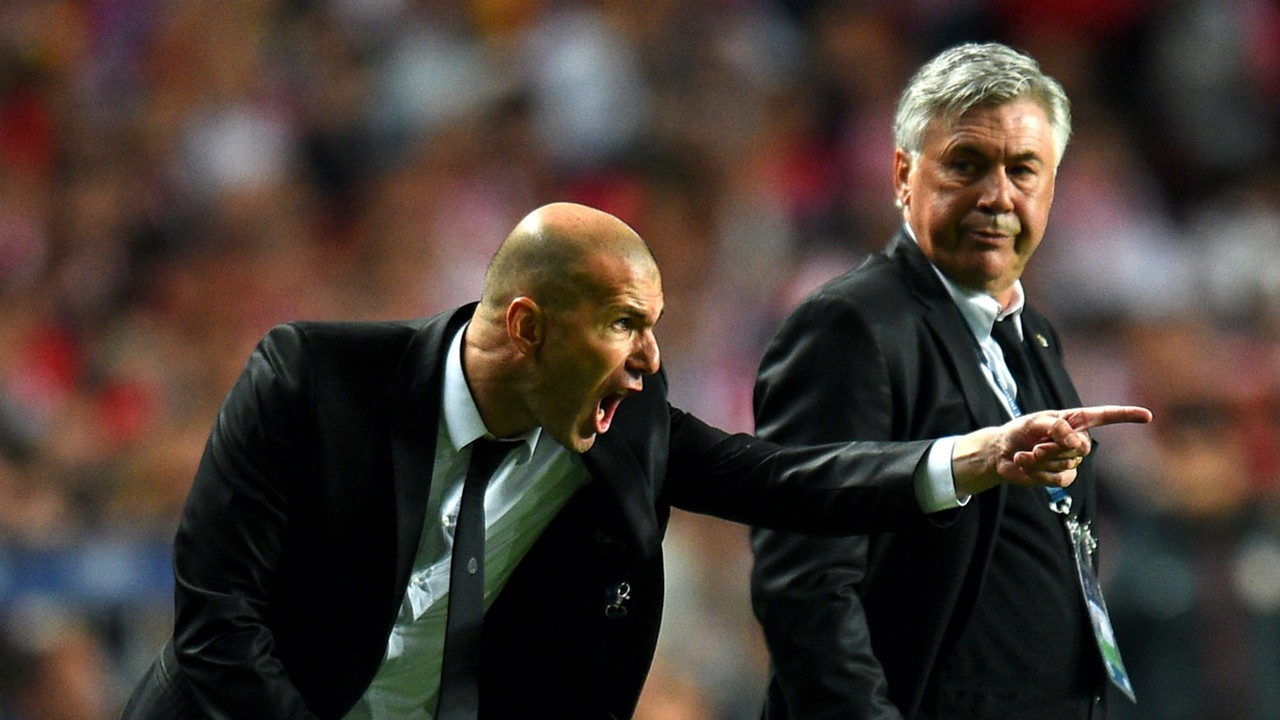

In [ ]:
### 推論実行前の画像
Image(filename='/content/yolov5/data/images/zidane.jpg', width=600)

推論を実行するともとの画像にBox、クラス名、confidenceを記載したjpgを出力します。  
jpgではなく、座標やクラス名などのテキストの結果が欲しい場合はオプションを指定することにより出力が可能です。  
そのオプションはコンペデータに対して推論する際に説明します。

detect: weights=['yolov5s.pt'], source=data/images/, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-25-g15e8c4c torch 1.9.0+cu111 CPU

100% 14.0M/14.0M [00:00<00:00, 19.0MB/s]

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/yolov5/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.339s)
image 2/2 /content/yolov5/data/images/zidane.jpg: 384x640 2 persons, 1 tie, Done. (0.259s)
Speed: 2.3ms pre-process, 298.8ms inference, 7.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp


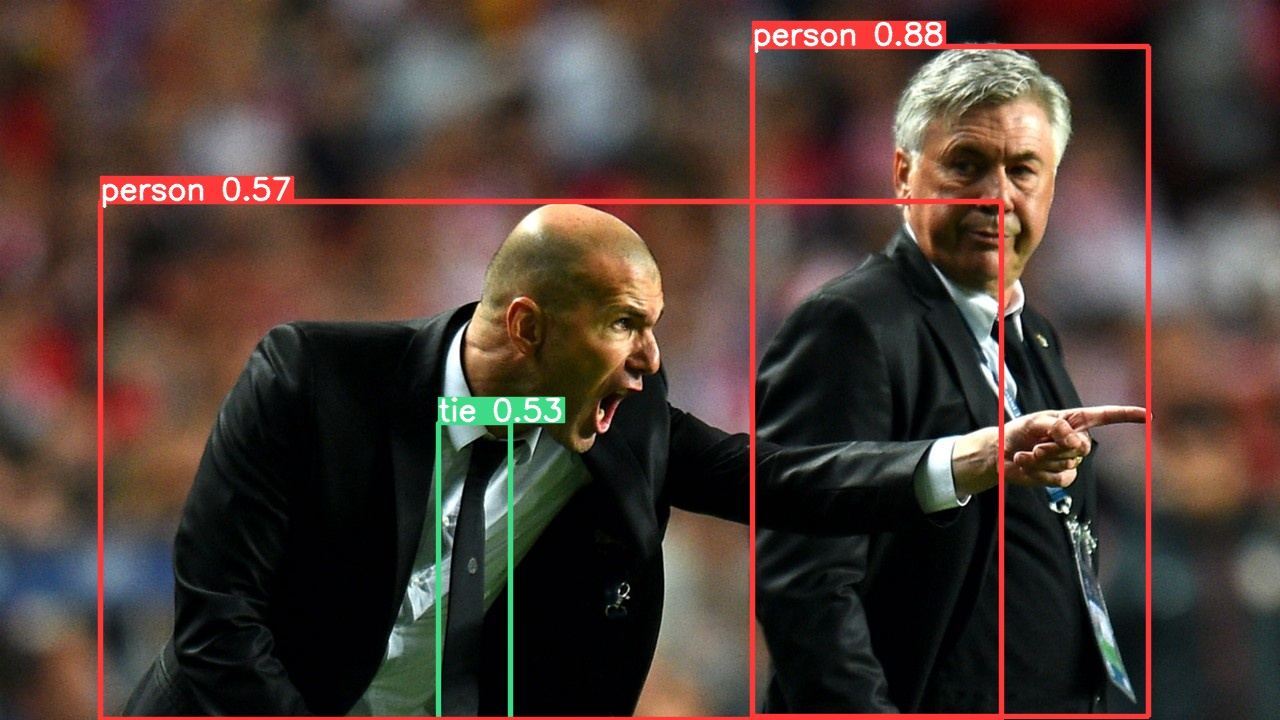

In [ ]:
# 推論の実行
### 推論時にはオプションで以下を指定します。
### 学習済み重みデータ、imgのサイズ、ボックスを表示させるconfidenceのしきい値、推論対象のデータ
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/
Image(filename='runs/detect/exp/zidane.jpg', width=600)

### 動作チェックが完了したところで今回のコンペのデータに対して学習を行っていきます

In [46]:
### 学習パラメータの設定
dim=512
batch_size=8
epochs = 5

yolo_ver = "yolov5x"

In [47]:
# コンペデータに対して学習を実行
### --dataオプションでsanwa.yamlを指定すると上記で作成したデータに対して学習が行なえます。
### yolov5 は s,m,l,xと複数のバージョンが有るのですが、--weightsオプションでバージョン指定を行えます。 s,m,l,xの順で性能がよいとされております。
### 詳しくはgitを参照してください。https://github.com/ultralytics/yolov5
!WANDB_MODE="dryrun" python train.py --img $dim --batch $batch_size --epochs $epochs --data /content/sanwa.yaml --weights yolov5x.pt --cache

train: weights=yolov5x.pt, cfg=, data=/content/sanwa.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=5, batch_size=8, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-25-g15e8c4c torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1

### 

### train実行結果の保存
train.pyを実行すると、"/content/yolov5/runs/train/exp/"に対してepochごとのlossや学習した重みデータなどの情報が出力されます。  
このnotebookではcontentで動作させており、colabのセッションを切ると出力結果も失われてしまうため、マイドライブへコピーしておきます

In [48]:
import datetime
from distutils.dir_util import copy_tree

now = datetime.datetime.now()
current_time = now.strftime("%Y-%m-%d-%H-%M")

src = "/content/yolov5/runs/train/exp/"

dest = f"{OUTPUT}models/yolo/{yolo_ver}_epoch{epochs}_{current_time}/train_log"
if not os.path.exists(dest):
    os.makedirs(dest)

copy_tree(src, dest)


['/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/train_log/val_batch0_labels.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/train_log/labels_correlogram.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/train_log/labels.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/train_log/events.out.tfevents.1634862470.ab212c418e74.580.0',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/train_log/hyp.yaml',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/train_log/train_batch2.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/train_log/results.csv',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoc

## YOLO 推論
detect.pyで推論を行います。  
### オプションについて
* --sourceオプション : 推論したいデータを指定
* --weightsオプション : 先程学習した重みデータを指定します。
* --imgオプション : 推論する画像サイズの指定
* --confオプション : BOXを表示するしきい値の設定
    * **0.5と大きな値を設定してしまうとBOXが出力されないケースもあるため0.001と低い値を設定しております**
* --save-txtオプション : txtファイルで推論結果を出力するためのオプション。特にパラメータ設定はいらず--save-txtと記述するだけでOKです。
    * 推論実行後の構成は以下の様になり、jpgにはBOXつきの画像、txtに座標データが出力されます
    ```
    /content/yolov5/runs/detect/
    └── exp
        ├── bus.jpg
        └── zidane.jpg
        └── labels
                ├── bus.txt
                └── zidane.txt
    ```
* --save-confオプション : 上記のtxtファイルにconfidenceが出力されます。


In [49]:
!python detect.py --source "../datasets/test" --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 512 --conf 0.001 --save-txt --save-conf

### マイドライブから重みデータの読み込み
#!python detect.py --source "../datasets/test" --weights '/content/drive/My Drive/python/CableIdentification/output/models/yolo/yolov5x_epoch5/weights/best.pt' --img 512 --conf 0.01 --save-txt --save-conf

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=../datasets/test, imgsz=[512, 512], conf_thres=0.001, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-25-g15e8c4c torch 1.9.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16280.875MB)

Fusing layers... 
Model Summary: 444 layers, 86267620 parameters, 0 gradients, 204.3 GFLOPs
image 1/2200 /content/datasets/test/0055471d.jpg: 512x512 2 Lightnings, 5 Lightning_Ts, 4 USB_Micro_Bs, 3 USB_Type_Cs, Done. (0.028s)
image 2/2200 /content/datasets/test/007bb9f0.jpg: 512x512 1 Dock, 3 Lightnings, 6 USB_Micro_Bs, 4 USB_Type_As, 9 USB_Type_Cs, Done. (0.029s)
image 3/2200 /content/datasets/test/00a34678.jpg: 512x512 1 Dock, 3 HDMIs, 1 Lightning_T, 13 USB

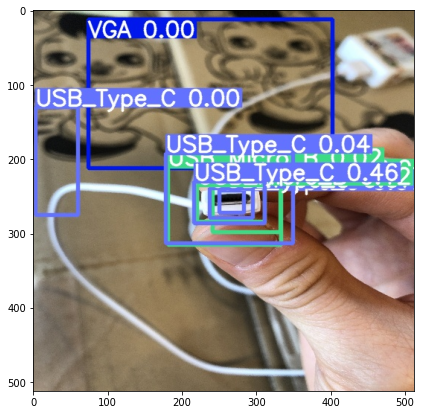

In [52]:
### 推論実行後の画像例
### thを0.001と非常に小さくしているためBOXがたくさん表示されます。
plot_img( read_img("/content/yolov5/runs/detect/exp/677aa0a2.jpg"))

In [53]:
### テキストでの推論結果
with open("/content/yolov5/runs/detect/exp/labels/677aa0a2.txt", mode="r") as f:
    data_ = f.read()
data_

'14 0.464844 0.21875 0.640625 0.390625 0.00101003\n13 0.0615234 0.395508 0.111328 0.283203 0.00114785\n7 0.55957 0.510742 0.177734 0.142578 0.00193042\n13 0.520508 0.501953 0.0644531 0.0585938 0.00205671\n7 0.501953 0.512695 0.296875 0.205078 0.0164163\n13 0.514648 0.493164 0.333984 0.236328 0.0368771\n13 0.519531 0.505859 0.113281 0.078125 0.0680073\n7 0.518555 0.506836 0.177734 0.0957031 0.11605\n13 0.514648 0.503906 0.185547 0.109375 0.463205\n'

In [55]:
### 実行結果をMYDRIVEへコピー

from distutils.dir_util import copy_tree
src = "/content/yolov5/runs/detect/exp/"

dest = f"{OUTPUT}models/yolo/{yolo_ver}_epoch{epochs}_{current_time}/result_inference/"
if not os.path.exists(dest):
    os.makedirs( dest)

copy_tree(src, dest)


['/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/result_inference/5bc6f085.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/result_inference/e541292b.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/result_inference/b23d7cbf.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/result_inference/2a51eb86.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/result_inference/b382d571.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/result_inference/736231f4.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2021-10-22-01-13/result_inference/62eb10ce.jpg',
 '/content/drive/My Drive/Python/Kaggle/nishika/output/models/yolo/yolov5x_epoch5_2

## submission.csvの作成
yolov5で推論したclassをdfに追記してsubmission.csvを作成します。

* labelsのフォーマットについて https://github.com/ultralytics/yolov5/blob/master/detect.pyから確認。
    * 1ラインにつき、(cls, x, y, w, h, conf)のフォーマット。
    * non_max_suppression関数によって、confidence順でソートされており、一番最後の行が一番確信度の高いBOXになる。
* 複数あるBOXの中でconfidenceが一番高いBOXを採用し、dfにclassと座標を追記
    * yoloで出力された座標形式からxmin,ymin,xmax,ymaxの形式へ戻しておく。

In [56]:
def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (0~1)
    voc  => [xmin, ymin, xmax, ymax]

    """ 
    bboxes = bboxes.copy().astype(float) 

    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height

    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]

    return bboxes

file_ids = []
PredictionStrings = []

for file_path in tqdm(glob('/content/yolov5/runs/detect/exp/labels/*.txt')):
    file_id = file_path.split('/')[-1].split('.')[0]
    w, h = 512,512
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)

    ### yoloでの推論結果は1つの　BOXにつき(cls, x, y, w, h, conf)の順で表示されるので(cls, conf, x, y, w, h)へ直しておく。
    ### BOXが複数出力される場合は、低い順に表示される
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 12).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    file_ids.append(file_id)
    PredictionStrings.append(' '.join(bboxes))

pred_df = pd.DataFrame({'id':file_ids,
                        'PredictionString':PredictionStrings})

  0%|          | 0/2200 [00:00<?, ?it/s]

In [57]:
class_ls = []
max_conf_ls = []
box_ls = []

for predstring in tqdm(pred_df["PredictionString"].values):
    listfromstr = predstring.split(" ")

    class_ls.append( int(listfromstr[-6]) )
    max_conf_ls.append( float(listfromstr[-5]) )
    box_ls.append( [int(x) for x in listfromstr[-4:] ] )

pred_df["classID"] = class_ls
pred_df["cofidence"] = max_conf_ls
pred_df["box"] = box_ls


  0%|          | 0/2200 [00:00<?, ?it/s]

In [58]:
pred_df["class"] = pred_df["classID"].apply(lambda x: dict_label[x])

In [59]:
pred_df["filename"] = pred_df["id"].apply(lambda x: x+".jpg")

In [60]:
pred_df

,id,PredictionString,classID,cofidence,box,class,filename
0,798001d1,4 0.001090829959 229 233 337 304 4 0.001113199...,4,0.396479,"[209, 165, 387, 307]",Lightning_T,798001d1.jpg
1,e5f7f1ed,13 0.001108380035 92 193 211 336 14 0.00140711...,13,0.646986,"[138, 198, 296, 283]",USB_Type_C,e5f7f1ed.jpg
2,848e3fb8,3 0.001094150008 159 163 365 339 7 0.001133979...,3,0.014917,"[202, 262, 300, 334]",Lightning,848e3fb8.jpg
3,d85681b5,6 0.001219270052 154 177 271 234 7 0.001260819...,6,0.535024,"[119, 160, 342, 268]",RJ_45,d85681b5.jpg
4,89b26ed6,4 0.00109099003 11 178 135 293 4 0.00112934003...,13,0.162107,"[324, 321, 390, 446]",USB_Type_C,89b26ed6.jpg
...,...,...,...,...,...,...,...
2195,2c090c0f,7 0.001033319975 41 251 201 364 11 0.001063319...,3,0.506478,"[238, 235, 303, 275]",Lightning,2c090c0f.jpg
2196,3c5d8ca3,3 0.001172930002 237 167 412 330 3 0.001189309...,3,0.500245,"[213, 233, 314, 309]",Lightning,3c5d8ca3.jpg
2197,2cfbedf5,6 0.001010059961 2 294 75 439 7 0.001032119966...,7,0.370211,"[177, 276, 345, 345]",USB_Micro_B,2cfbedf5.jpg
2198,8689350c,6 0.001043920056 2 0 156 49 7 0.001087110024 3...,13,0.684617,"[173, 236, 332, 327]",USB_Type_C,8689350c.jpg


In [61]:
pred_df.to_csv(f"{OUTPUT}models/yolo/{yolo_ver}_epoch{epochs}_{current_time}/pred_yolo.csv")

In [62]:
submission = pred_df[["filename","class"]]

In [63]:
submission

,filename,class
0,798001d1.jpg,Lightning_T
1,e5f7f1ed.jpg,USB_Type_C
2,848e3fb8.jpg,Lightning
3,d85681b5.jpg,RJ_45
4,89b26ed6.jpg,USB_Type_C
...,...,...
2195,2c090c0f.jpg,Lightning
2196,3c5d8ca3.jpg,Lightning
2197,2cfbedf5.jpg,USB_Micro_B
2198,8689350c.jpg,USB_Type_C


In [64]:
submission.to_csv(f"{OUTPUT}models/yolo/{yolo_ver}_epoch{epochs}_{current_time}/submission.csv", index=False)

# EOF
